<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.pipeline import  make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

random_state = 12345

In [2]:
df_test = pd.read_csv("/datasets/gold_recovery_test.csv")
df_train = pd.read_csv("/datasets/gold_recovery_train.csv")
df_full = pd.read_csv("/datasets/gold_recovery_full.csv")

In [3]:
def view(df):
    print(df.info())
    print('-----------------------')
    print(df.describe())
    print('-----------------------')
    print(df.head(5))
    print('-----------------------')
    print(df.shape)
    return view

In [4]:
view(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


<function __main__.view(df)>

In [5]:
#df_train.dropna(inplace=True)

In [6]:
# pd.options.mode.chained_assignment = None # Убираем вывод сообщения SettingWithCopyWarning
# for col in df_train.columns[1::]:
#     col_mean = df_train[col].mean(skipna=True)
#     for i in range(df_train.shape[0]):
#         if pd.isna(df_train[col][i]):
#             df_train[col][i] = col_mean

In [7]:
view(df_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


<function __main__.view(df)>

Технологический процесс (из задания)

    Rougher feed — исходное сырье
    Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    Xanthate **— ксантогенат (промотер, или активатор флотации);
    Sulphate — сульфат (на данном производстве сульфид натрия);
    Depressant — депрессант (силикат натрия).
    Rougher process (англ. «грубый процесс») — флотация
    Rougher tails — отвальные хвосты
    Float banks — флотационная установка
    Cleaner process — очистка
    Rougher Au — черновой концентрат золота
    Final Au — финальный концентрат золота
    
Параметры этапов

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи

ag, pb, sol, au - Серебро, Свинец, Соль, Золото

    rougher.input.feed_ag(pb, sol, au) - концентрация исходного сырье ag, pb, sol, au
    rougher.input.feed_rate - скорость подачи сырья
    rougher.input.feed_size - размер гранул сырья
    rougher.input.floatbank_10_sulfate - подача флотационных реагентов 
    rougher.output.concentrate_ag - концентрация на выходе 
    rougher.output.tail_ag - отвальные хвосты  после флотации
    rougher.output.recovery - Эффективность обогащения после флотации
    rougher.state.floatbank10_a_air(level) - параметры объема воздуха и уровня жидкости
    rougher.calculation - расчётные характеристики
    
    primary_cleaner.input.sulfate - реагенты
    primary_cleaner.input.feed_size - размер гранул сырья на входе
    primary_cleaner.output.concentrate_ag - концентрация на выходе
    primary_cleaner.output.tail_ag - отвальные хвосты первичной очистки
    primary_cleaner.state.floatbank8_a_air(level) - параметры объема воздуха и уровня жидкости
    
    secondary_cleaner.output.tail_ag - отвальные хвосты после вторичной очистки
    secondary_cleaner.state.floatbank2_a_air(level) - параметры объема воздуха и уровня жидкости, характеризующие текущее состояние этапа
    final.output.recovery - эффективность обогащения финального концентрата
    final.output.concentrate_ag - финальный концентрат 
    final.output.tail_ag - финальные отвальные хвосты 

In [8]:
step = collections.Counter()
type_step = collections.Counter()
df = collections.Counter()
list_columns = [i for i in df_train.columns if i not in df_test.columns]
for i in list_columns:
    words = list(map(str,i.split(".")))
    step[words[0]] += 1
    type_step[words[1]] += 1
    df[words[2]] += 1

In [9]:
list_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [10]:
step,"-------------",type_step,"----------",df

(Counter({'final': 9,
          'primary_cleaner': 8,
          'rougher': 13,
          'secondary_cleaner': 4}),
 '-------------',
 Counter({'output': 30, 'calculation': 4}),
 '----------',
 Counter({'concentrate_ag': 3,
          'concentrate_pb': 3,
          'concentrate_sol': 3,
          'concentrate_au': 3,
          'recovery': 2,
          'tail_ag': 4,
          'tail_pb': 4,
          'tail_sol': 4,
          'tail_au': 4,
          'sulfate_to_au_concentrate': 1,
          'floatbank10_sulfate_to_au_feed': 1,
          'floatbank11_sulfate_to_au_feed': 1,
          'au_pb_ratio': 1}))

In [11]:
df_train.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [12]:
df_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [13]:
df_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [14]:
imputer = KNNImputer(n_neighbors=2)
df_train.loc[:, 'final.output.concentrate_ag': 'secondary_cleaner.state.floatbank6_a_level'] = (
    imputer.fit_transform(df_train.loc[:, 'final.output.concentrate_ag': 'secondary_cleaner.state.floatbank6_a_level']))

In [15]:
df_train.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [16]:
def recovery(concentrate, feed, tail):
    return concentrate * (feed - tail) / (feed * (concentrate - tail)) * 100  

In [17]:
df_train['counted_recovery'] = recovery(df_train['rougher.output.concentrate_au'], df_train['rougher.input.feed_au'],
                                        df_train['rougher.output.tail_au'])
df_train['counted_recovery'].describe()

count    1.573100e+04
mean              NaN
std               NaN
min              -inf
25%      7.969594e+01
50%      8.547481e+01
75%      9.057834e+01
max               inf
Name: counted_recovery, dtype: float64

In [18]:
df_train_mae = df_train[['rougher.output.recovery','counted_recovery']].dropna()

In [19]:
def mae(recovery, counted_recovery):
    mae = 1 / len(recovery) * (abs(recovery - counted_recovery)).sum() 
    return mae

mae(df_train_mae['rougher.output.recovery'], df_train_mae['counted_recovery'])

inf

In [20]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_train = df_train.set_index(['date'])

In [21]:
imputer = KNNImputer(n_neighbors=2)
df_test.loc[:, df_test.columns != 'date' ] = imputer.fit_transform(df_test.loc[:, df_test.columns != 'date' ])

In [22]:
df_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [23]:
imputer = KNNImputer(n_neighbors=2)
df_full.loc[:, df_full.columns != 'date' ] = imputer.fit_transform(df_full.loc[:, df_full.columns != 'date' ])

In [24]:
df_full.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [25]:
df_full.duplicated().sum()

0

In [26]:
df_test_full = pd.DataFrame(data=df_full, index=df_test.index)
df_test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                5856 non-null   object 
 1   final.output.concentrate_ag                         5856 non-null   float64
 2   final.output.concentrate_pb                         5856 non-null   float64
 3   final.output.concentrate_sol                        5856 non-null   float64
 4   final.output.concentrate_au                         5856 non-null   float64
 5   final.output.recovery                               5856 non-null   float64
 6   final.output.tail_ag                                5856 non-null   float64
 7   final.output.tail_pb                                5856 non-null   float64
 8   final.output.tail_sol                               5856 non-null   float64
 9

## Анализ данных

In [27]:
#print("До флотации")
#print("Концентрация Серебра:{: 0.2f},Концентрация Свинца:{: 0.2f},Концентрация Золота:{: 0.2f}".
#format(without_nan["rougher.input.feed_ag"].mean(),
#without_nan["rougher.input.feed_pb"].mean(),
#without_nan["rougher.input.feed_au"].mean()))
#print('----------------------------------------------------------------')
#print("После флотации")
#print("Коцентрация Серебра:{: 0.2f},Концентрация Свинца:{: 0.2f},Концентрация Золота:{: 0.2f}".
#format(without_nan["rougher.output.concentrate_ag"].mean(),without_nan["rougher.output.concentrate_pb"].mean(),without_nan["rougher.output.concentrate_au"].mean()))
#print('----------------------------------------------------------------')
#print("После первичной очистки")
#print("Концентрация Серебра:{: 0.2f},Концентрация Свинца:{: 0.2f},Концентрация Золота:{: 0.2f}".
#format(without_nan["primary_cleaner.output.concentrate_ag"].mean(),without_nan["primary_cleaner.output.concentrate_pb"].mean(),without_nan["primary_cleaner.output.concentrate_au"].mean()))
#print('----------------------------------------------------------------')
#print("После вторичной очистки")
#print("Концентрация Серебра:{: 0.2f},Концентрация Свинца:{: 0.2f},Концентрация Золота:{: 0.2f}".
#format(without_nan["final.output.concentrate_ag"].mean(),without_nan["final.output.concentrate_pb"].mean(),without_nan["final.output.concentrate_au"].mean()))

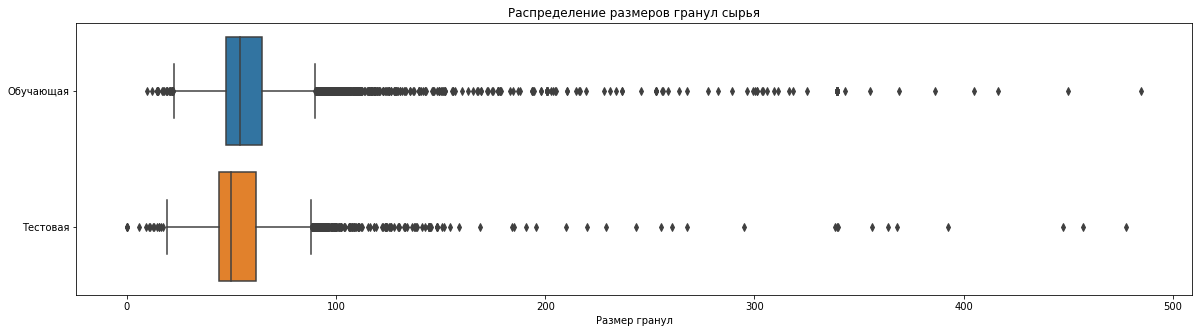

In [28]:
plt.figure(figsize=(20,5))
sns.boxplot(data=(df_train['rougher.input.feed_size'], 
                  df_test['rougher.input.feed_size']), orient='h').set(xlabel='Размер гранул', title='Распределение размеров гранул сырья')
plt.yticks([0,1], ['Обучающая', 'Тестовая']);

Сравнил распределения размеров гранул сырья на обучающей и тестовой выборках.

In [29]:
def deviation_compare(df1, column1, df2, column2):
    plt.figure(figsize=(17,5))
    sns.distplot(df1[column1], color='g').set(xlabel='Среднее по значениям', ylabel='Плотность частоты', title='Распределение по размерам гранул сырья');
    sns.distplot(df2[column2], color='b').set(xlabel='Среднее по значениям', ylabel='Плотность частоты');

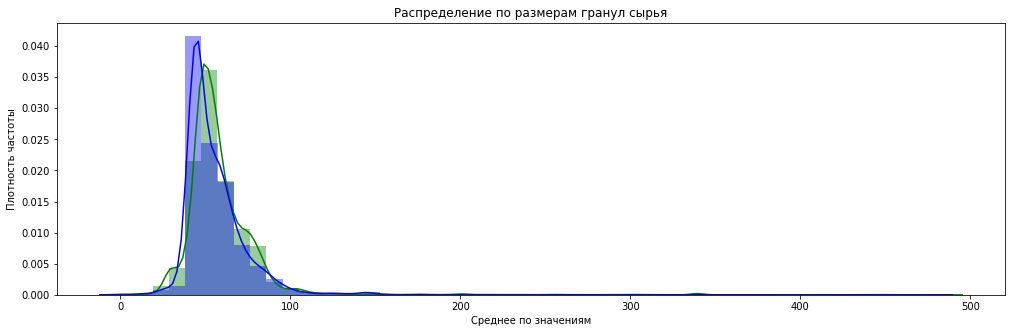

In [30]:
deviation_compare(df_train, 'rougher.input.feed_size', df_test, 'rougher.input.feed_size')

Графики показывают, что размеры гранул сырья на обучающей и тестовой выборках не сильно отличаются друг от друга, что в свою очередь не окажет существенного влияния на построение модели.

In [31]:
df_sum = df_train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag',
                   'rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb',
                   'rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au',
                   'rougher.input.feed_sol', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']]
df_sum

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_sol,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_sol,final.output.concentrate_sol
date,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,11.500771,8.547551,6.055403,2.284912,7.101074,10.389648,9.889648,6.486150,19.793808,34.174427,42.192020,36.808594,28.029297,19.529297,5.507324
2016-01-15 01:00:00,6.161113,11.615865,8.558743,6.029369,2.266033,7.278807,10.497069,9.968944,6.478583,20.050975,34.118526,42.701629,35.753385,28.067063,19.369147,5.257781
2016-01-15 02:00:00,6.116455,11.695753,8.603505,6.055926,2.159622,7.216833,10.354494,10.213995,6.362222,19.737170,33.969464,42.657501,35.971630,27.454037,19.167579,5.383759
2016-01-15 03:00:00,6.043309,11.915047,7.221879,6.047977,2.037807,7.175616,8.496563,9.977019,6.118189,19.320810,28.260743,42.689819,36.862241,27.341277,15.978538,4.858634
2016-01-15 04:00:00,6.060915,12.411054,9.089428,6.148599,1.786875,7.240205,9.986786,10.142511,5.663707,19.216101,33.044932,42.774141,34.347666,27.041023,19.199864,4.939416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,6.091855,11.124896,6.559174,3.224920,4.617558,10.984003,12.445966,11.356233,5.335862,18.603550,32.940215,46.713954,37.369774,30.068876,7.056338,6.803482
2018-08-18 07:59:59,6.121323,11.425983,6.612376,3.195978,4.144989,10.888213,12.623947,11.349355,4.838619,18.441436,32.925325,46.866780,38.591551,29.783972,7.542264,6.862249
2018-08-18 08:59:59,5.970515,8.523497,7.128896,3.109998,4.020002,8.955135,12.633558,11.434366,4.525061,15.111231,31.856742,46.795691,40.074026,22.786467,7.941900,6.886013


Исследую суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Создал суммарный датафрейм.

In [32]:
df_sum_input_feed = df_sum.iloc[:, 0::4]
df_sum_input_feed

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.input.feed_sol
date,,,,
2016-01-15 00:00:00,6.100378,2.284912,6.486150,36.808594
2016-01-15 01:00:00,6.161113,2.266033,6.478583,35.753385
2016-01-15 02:00:00,6.116455,2.159622,6.362222,35.971630
2016-01-15 03:00:00,6.043309,2.037807,6.118189,36.862241
2016-01-15 04:00:00,6.060915,1.786875,5.663707,34.347666
...,...,...,...,...
2018-08-18 06:59:59,6.091855,4.617558,5.335862,37.369774
2018-08-18 07:59:59,6.121323,4.144989,4.838619,38.591551
2018-08-18 08:59:59,5.970515,4.020002,4.525061,40.074026


In [33]:
df_sum_input_feed['sum'] = df_sum_input_feed.sum(axis=1)

df_sum_input_feed

/tmp/ipykernel_330/4258115563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum_input_feed['sum'] = df_sum_input_feed.sum(axis=1)


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.input.feed_sol,sum
date,,,,,
2016-01-15 00:00:00,6.100378,2.284912,6.486150,36.808594,51.680034
2016-01-15 01:00:00,6.161113,2.266033,6.478583,35.753385,50.659114
2016-01-15 02:00:00,6.116455,2.159622,6.362222,35.971630,50.609929
2016-01-15 03:00:00,6.043309,2.037807,6.118189,36.862241,51.061546
2016-01-15 04:00:00,6.060915,1.786875,5.663707,34.347666,47.859163
...,...,...,...,...,...
2018-08-18 06:59:59,6.091855,4.617558,5.335862,37.369774,53.415050
2018-08-18 07:59:59,6.121323,4.144989,4.838619,38.591551,53.696482
2018-08-18 08:59:59,5.970515,4.020002,4.525061,40.074026,54.589604


Создал столбец с суммарной концентрацией в руде

In [34]:
df_sum_rougher = df_sum.iloc[:, 1::4]
df_sum_rougher['sum'] = df_sum_rougher.sum(axis=1)
df_sum_rougher

/tmp/ipykernel_330/248112994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum_rougher['sum'] = df_sum_rougher.sum(axis=1)


,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au,rougher.output.concentrate_sol,sum
date,,,,,
2016-01-15 00:00:00,11.500771,7.101074,19.793808,28.029297,66.424950
2016-01-15 01:00:00,11.615865,7.278807,20.050975,28.067063,67.012710
2016-01-15 02:00:00,11.695753,7.216833,19.737170,27.454037,66.103793
2016-01-15 03:00:00,11.915047,7.175616,19.320810,27.341277,65.752751
2016-01-15 04:00:00,12.411054,7.240205,19.216101,27.041023,65.908382
...,...,...,...,...,...
2018-08-18 06:59:59,11.124896,10.984003,18.603550,30.068876,70.781325
2018-08-18 07:59:59,11.425983,10.888213,18.441436,29.783972,70.539603
2018-08-18 08:59:59,8.523497,8.955135,15.111231,22.786467,55.376330


Также сделал для чернового

In [35]:
df_sum_primary_cleaner = df_sum.iloc[:, 2::4]
df_sum_primary_cleaner['sum'] = df_sum_primary_cleaner.sum(axis=1)
df_sum_primary_cleaner

/tmp/ipykernel_330/1548635833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum_primary_cleaner['sum'] = df_sum_primary_cleaner.sum(axis=1)


,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_sol,sum
date,,,,,
2016-01-15 00:00:00,8.547551,10.389648,34.174427,19.529297,72.640924
2016-01-15 01:00:00,8.558743,10.497069,34.118526,19.369147,72.543485
2016-01-15 02:00:00,8.603505,10.354494,33.969464,19.167579,72.095042
2016-01-15 03:00:00,7.221879,8.496563,28.260743,15.978538,59.957723
2016-01-15 04:00:00,9.089428,9.986786,33.044932,19.199864,71.321010
...,...,...,...,...,...
2018-08-18 06:59:59,6.559174,12.445966,32.940215,7.056338,59.001692
2018-08-18 07:59:59,6.612376,12.623947,32.925325,7.542264,59.703912
2018-08-18 08:59:59,7.128896,12.633558,31.856742,7.941900,59.561096


И соответственно после 1й очистки

In [36]:
df_sum_final = df_sum.iloc[:, 3::4]
df_sum_final['sum'] = df_sum_final.sum(axis=1)
df_sum_final

/tmp/ipykernel_330/4225089310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sum_final['sum'] = df_sum_final.sum(axis=1)


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_au,final.output.concentrate_sol,sum
date,,,,,
2016-01-15 00:00:00,6.055403,9.889648,42.192020,5.507324,63.644396
2016-01-15 01:00:00,6.029369,9.968944,42.701629,5.257781,63.957723
2016-01-15 02:00:00,6.055926,10.213995,42.657501,5.383759,64.311180
2016-01-15 03:00:00,6.047977,9.977019,42.689819,4.858634,63.573449
2016-01-15 04:00:00,6.148599,10.142511,42.774141,4.939416,64.004667
...,...,...,...,...,...
2018-08-18 06:59:59,3.224920,11.356233,46.713954,6.803482,68.098589
2018-08-18 07:59:59,3.195978,11.349355,46.866780,6.862249,68.274362
2018-08-18 08:59:59,3.109998,11.434366,46.795691,6.886013,68.226068


И в конце финальный концентрат. Далее посмотрю распределение на каждом из этапов обработки.

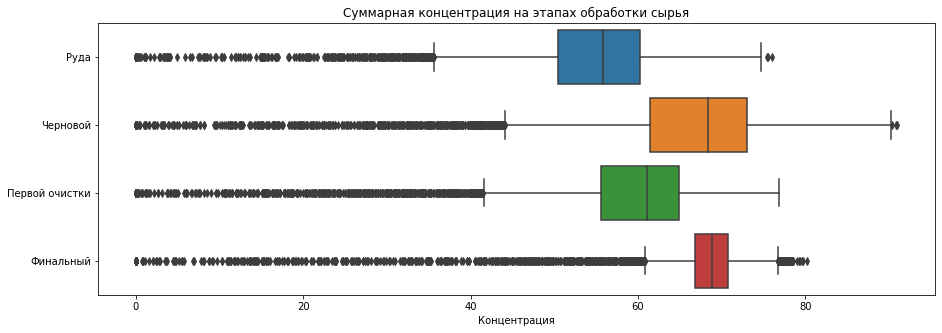

In [37]:
plt.figure(figsize=(15,5))
sns.boxplot(data=(df_sum_input_feed['sum'], 
                  df_sum_rougher['sum'], 
                  df_sum_primary_cleaner['sum'], 
                  df_sum_final['sum']), orient='h').set(xlabel='Концентрация', title='Суммарная концентрация на этапах обработки сырья')
plt.yticks([0,1,2,3], ['Руда', 'Черновой', 'Первой очистки', 'Финальный']);

In [38]:
df_sum_input_feed[df_sum_input_feed['sum'] == 0]

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.input.feed_sol,sum
date,,,,,
2016-01-19 03:00:00,0.0,0.0,0.0,0.0,0.0
2016-01-19 04:00:00,0.0,0.0,0.0,0.0,0.0
2016-01-19 05:00:00,0.0,0.0,0.0,0.0,0.0
2016-01-19 06:00:00,0.0,0.0,0.0,0.0,0.0
2016-01-19 07:00:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2018-07-20 10:59:59,0.0,0.0,0.0,0.0,0.0
2018-07-20 11:59:59,0.0,0.0,0.0,0.0,0.0
2018-07-21 23:59:59,0.0,0.0,0.0,0.0,0.0


In [39]:
(df_sum_input_feed==0).sum()

rougher.input.feed_ag     1173
rougher.input.feed_pb     1173
rougher.input.feed_au     1173
rougher.input.feed_sol    1176
sum                       1173
dtype: int64

In [40]:
df_sum_input_feed= df_sum_input_feed[(df_sum_input_feed['rougher.input.feed_ag'] !=0) & 
         (df_sum_input_feed['rougher.input.feed_pb'] !=0) &
         (df_sum_input_feed['rougher.input.feed_au'] !=0) &
         (df_sum_input_feed['rougher.input.feed_sol'] != 0)]
(df_sum_input_feed==0).sum()

rougher.input.feed_ag     0
rougher.input.feed_pb     0
rougher.input.feed_au     0
rougher.input.feed_sol    0
sum                       0
dtype: int64

Проверил нулевые значения и избавился от них

In [41]:
df_train= df_train[(df_train['rougher.input.feed_au'] !=0) & 
         (df_train['rougher.output.concentrate_au'] !=0) &
         (df_train['primary_cleaner.output.concentrate_au'] !=0) &
         (df_train['final.output.concentrate_au'] != 0)]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15066 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         15066 non-null  float64
 1   final.output.concentrate_pb                         15066 non-null  float64
 2   final.output.concentrate_sol                        15066 non-null  float64
 3   final.output.concentrate_au                         15066 non-null  float64
 4   final.output.recovery                               15066 non-null  float64
 5   final.output.tail_ag                                15066 non-null  float64
 6   final.output.tail_pb                                15066 non-null  float64
 7   final.output.tail_sol                               15066 non-null  float64
 8   final.output.tail_au                     

In [42]:
test_columns =  set(df_test.columns)

In [43]:
#df_train_features = df_train.loc[:, test_columns]
#df_train_features
#df_train_target = df_train.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
#df_train_target

In [44]:
#код ревьюера
df_test.drop('date', axis=1, inplace=True)
df_train_features = df_train[df_test.columns]
print(df_train_features.shape)
df_train_target = df_train[['rougher.output.recovery', 'final.output.recovery']]
print(df_train_target.shape)

(15066, 52)
(15066, 2)


In [45]:
df_train_rougher_features = df_train_features.filter(regex='^rougher',axis=1)
df_train_rougher_features.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
2016-01-15 01:00:00,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2016-01-15 02:00:00,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
2016-01-15 03:00:00,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
2016-01-15 04:00:00,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128


In [46]:
final_columns = set(df_train_features) - set(df_train_rougher_features)
df_train_final_features = df_train_features.loc[:, final_columns]
df_train_final_features.head()

,primary_cleaner.input.sulfate,primary_cleaner.state.floatbank8_b_level,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank4_a_level,primary_cleaner.state.floatbank8_d_level,primary_cleaner.input.depressant,secondary_cleaner.state.floatbank2_b_air,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_c_air,secondary_cleaner.state.floatbank6_a_air,...,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank6_a_level,primary_cleaner.input.feed_size,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank5_b_air,primary_cleaner.state.floatbank8_c_level,secondary_cleaner.state.floatbank4_b_air
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,127.092003,-516.403442,-495.262817,-502.488007,-493.428131,10.128295,23.893660,1549.775757,1549.873901,14.151341,...,-500.470978,-501.406281,-605.841980,7.25,-499.340973,14.016835,21.940409,8.079666,-498.666595,12.099931
2016-01-15 01:00:00,125.629232,-499.865889,-500.085473,-505.503262,-498.931665,10.296251,23.889530,1576.166671,1575.994189,13.998353,...,-500.582168,-500.372428,-599.787184,7.25,-499.446897,13.992281,22.085714,7.984757,-499.315107,11.950531
2016-01-15 02:00:00,123.819808,-500.607762,-499.442343,-502.520901,-499.827444,11.316280,23.886657,1601.556163,1602.003542,14.028663,...,-500.517572,-499.951928,-601.427363,7.25,-499.901982,14.015015,23.957717,8.013877,-500.870069,11.912783
2016-01-15 03:00:00,122.270188,-499.677094,-500.008812,-500.857308,-500.052575,11.322140,23.955516,1599.968720,1600.304144,14.005551,...,-500.255908,-499.848796,-599.996129,7.25,-499.944710,14.036510,23.954443,7.977324,-500.727997,11.999550
2016-01-15 04:00:00,117.988169,-500.323246,-500.083811,-499.838632,-500.593010,11.913613,23.955345,1601.339707,1599.581894,13.996647,...,-500.356035,-500.593614,-601.496691,7.25,-499.990309,14.027298,23.958945,7.894242,-500.888152,11.953070


In [47]:
df_test_rougher_features = df_test.filter(regex='^rougher',axis=1)
df_test_rougher_features.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,...,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807
1,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,...,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514
2,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,...,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340
3,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,...,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986
4,11.327427,4.767383,488.248117,63.315324,41.269161,11.290425,13.607257,5.738081,13.650053,5.739634,...,1304.658848,-399.511519,1306.455515,-399.050685,1248.699349,-400.876894,1058.839106,-398.988239,949.645313,-399.277632


In [48]:
df_test_full = pd.DataFrame(data=df_full, index=df_test.index)
df_test_full.dropna(inplace=True)
df_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                5856 non-null   object 
 1   final.output.concentrate_ag                         5856 non-null   float64
 2   final.output.concentrate_pb                         5856 non-null   float64
 3   final.output.concentrate_sol                        5856 non-null   float64
 4   final.output.concentrate_au                         5856 non-null   float64
 5   final.output.recovery                               5856 non-null   float64
 6   final.output.tail_ag                                5856 non-null   float64
 7   final.output.tail_pb                                5856 non-null   float64
 8   final.output.tail_sol                               5856 non-null   float64
 9

In [49]:
df_test_final_features = df_test.loc[:, final_columns]
df_test_final_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5856 non-null   float64
 1   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 2   secondary_cleaner.state.floatbank3_a_level  5856 non-null   float64
 3   secondary_cleaner.state.floatbank4_a_level  5856 non-null   float64
 4   primary_cleaner.state.floatbank8_d_level    5856 non-null   float64
 5   primary_cleaner.input.depressant            5856 non-null   float64
 6   secondary_cleaner.state.floatbank2_b_air    5856 non-null   float64
 7   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 9   secondary_cleaner.state.floatbank6_a_air    5856 non-null   float64
 10  secondary_cl

In [50]:
df_full = df_full[(df_full['rougher.input.feed_au'] !=0) & 
         (df_full['rougher.output.concentrate_au'] !=0) &
         (df_full['primary_cleaner.output.concentrate_au'] !=0) &
         (df_full['final.output.concentrate_au'] != 0)]
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [51]:
df_test_full = pd.DataFrame(data=df_full, index=df_test.index)
df_test_full.dropna(inplace=True)
df_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5181 entries, 0 to 5855
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                5181 non-null   object 
 1   final.output.concentrate_ag                         5181 non-null   float64
 2   final.output.concentrate_pb                         5181 non-null   float64
 3   final.output.concentrate_sol                        5181 non-null   float64
 4   final.output.concentrate_au                         5181 non-null   float64
 5   final.output.recovery                               5181 non-null   float64
 6   final.output.tail_ag                                5181 non-null   float64
 7   final.output.tail_pb                                5181 non-null   float64
 8   final.output.tail_sol                               5181 non-null   float64
 9

In [52]:
df_test_rougher_features = pd.DataFrame(data=df_test_rougher_features, index=df_test_full.index)
df_test_final_features = pd.DataFrame(data=df_test_final_features, index=df_test_full.index)

In [53]:
df_test_rougher_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5181 entries, 0 to 5855
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               5181 non-null   float64
 1   rougher.input.feed_pb               5181 non-null   float64
 2   rougher.input.feed_rate             5181 non-null   float64
 3   rougher.input.feed_size             5181 non-null   float64
 4   rougher.input.feed_sol              5181 non-null   float64
 5   rougher.input.feed_au               5181 non-null   float64
 6   rougher.input.floatbank10_sulfate   5181 non-null   float64
 7   rougher.input.floatbank10_xanthate  5181 non-null   float64
 8   rougher.input.floatbank11_sulfate   5181 non-null   float64
 9   rougher.input.floatbank11_xanthate  5181 non-null   float64
 10  rougher.state.floatbank10_a_air     5181 non-null   float64
 11  rougher.state.floatbank10_a_level   5181 no

In [54]:
df_test_final_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5181 entries, 0 to 5855
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5181 non-null   float64
 1   primary_cleaner.state.floatbank8_b_level    5181 non-null   float64
 2   secondary_cleaner.state.floatbank3_a_level  5181 non-null   float64
 3   secondary_cleaner.state.floatbank4_a_level  5181 non-null   float64
 4   primary_cleaner.state.floatbank8_d_level    5181 non-null   float64
 5   primary_cleaner.input.depressant            5181 non-null   float64
 6   secondary_cleaner.state.floatbank2_b_air    5181 non-null   float64
 7   primary_cleaner.state.floatbank8_a_air      5181 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5181 non-null   float64
 9   secondary_cleaner.state.floatbank6_a_air    5181 non-null   float64
 10  secondary_cl

In [55]:
df_test_target = df_test_full.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
df_test_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5181 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  5181 non-null   float64
 1   final.output.recovery    5181 non-null   float64
dtypes: float64(2)
memory usage: 121.4 KB


## Модель

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера v2:</b>
Спасибо, два недочёта исправлено. Понимаю, что возникают сложности с проектом. Поэтому предлагаю программу минимум. Использовать две модели: линейная регрессия и случайный лес. Оценить их при помощи cross_validation_score. Выбрать наилучшую. И проверить затем проверить её эффективность на тестовой выборке. Если получишь sMAPE меньше 12 процентов, то гуд.
</div>
<font color='blue'><b>Но нужно кое-что поправить и добавить, решил собрать всё в одни список:</b></font>
<div class="alert alert-block alert-danger">
<ul>1) Использовать линейную регрессию и случайный лес</ul>
<ul>2) Оценить их с помощью cross_validation_score</ul>
<ul>3) Получить sMAPE меньше 12 процентов на тестовой выборке</ul>
</div>

<font color='blue'><b>Уверен, что ты справишься, буду ждать твою работу</b></font>

In [56]:
def data_to_StandardScaler(data):
    sc = StandardScaler()
    data = sc.fit_transform(data)
    return data

In [57]:
df_train_rougher_features = data_to_StandardScaler(df_train_rougher_features)
df_train_final_features = data_to_StandardScaler(df_train_final_features)

df_test_rougher_features = data_to_StandardScaler(df_test_rougher_features)
df_test_final_features = data_to_StandardScaler(df_test_final_features)

Выполнил масштабирование путем стандартизации данных с использованием StandardScaler
Преобразовал данные функцией transform() и написал функцию data_to_StandardScaler(data)

In [58]:
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(random_state=12345)

Использую 2 модели Линейную регрессию и случайный лес

In [59]:
random_forest_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [74]:
parameters_grid = {
    'n_estimators' : range(1, 100, 25),
    'max_depth' : range(1, 6)
}

Использовал гиперпараметры и создал словарь гиперпараметров

In [75]:
def sMAPE(predict, target):
    sMAPE = (abs(target - predict) / ((abs(target) + abs(predict)) / 2)).mean() * 100
    return sMAPE

Буду использовать стратегию кросс-валидации для подбора оптимальных параметров

In [76]:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=12345)

In [77]:
score = make_scorer(sMAPE, greater_is_better=False)

In [78]:
grid_cv = GridSearchCV(random_forest_model, parameters_grid, scoring=score, cv=cv)

Запущу подбор оптимальных параметров для rougher_features

In [79]:
%%time
grid_cv.fit(df_train_rougher_features, df_train_target['rougher.output.recovery'])

CPU times: user 1min 35s, sys: 73.5 ms, total: 1min 35s
Wall time: 1min 36s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=12345, test_size=0.3, train_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(1, 100, 25)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [80]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-5.663545826436608
{'max_depth': 5, 'n_estimators': 76}


Запущу подбор оптимальных параметров для final_features

In [81]:
%%time
grid_cv.fit(df_train_final_features, df_train_target['final.output.recovery'])

CPU times: user 2min 12s, sys: 81.8 ms, total: 2min 12s
Wall time: 2min 14s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=12345, test_size=0.3, train_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(1, 100, 25)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [82]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-8.731567033329528
{'max_depth': 5, 'n_estimators': 76}


Полученные значения гиперпараметров буду использовать для вычисления итоговой метрики sMAPE

Напишу функцию для расчёта итогового sMAPE:

In [83]:
def sMAPE(predict, target):
    sMAPE = (abs(target - predict) / ((abs(target) + abs(predict)) / 2)).mean() * 100
    return sMAPE

In [84]:
def train_cross_val_predicts_and_total_sMAPE(model):
    rouger_predict = cross_val_predict(model, df_train_rougher_features, df_train_target['rougher.output.recovery'], cv=3)
    final_predict = cross_val_predict(model, df_train_final_features, df_train_target['final.output.recovery'], cv=3)
    rouger_sMAPE = sMAPE(rouger_predict, df_train_target['rougher.output.recovery'])
    final_sMAPE = sMAPE(final_predict, df_train_target['final.output.recovery'])
    total_sMAPE = .25 * rouger_sMAPE + .75 * final_sMAPE
    print('sMAPE для rougher.output.recovery:', rouger_sMAPE)
    print('sMAPE для final.output.recovery:', final_sMAPE)
    print('Итоговое sMAPE:', total_sMAPE)
    return 

In [85]:
def test_predicts_and_total_sMAPE(model):
    model.fit(df_train_rougher_features, df_train_target['rougher.output.recovery'])
    rouger_predict = model.predict(df_test_rougher_features)
    
    model.fit(df_train_final_features, df_train_target['final.output.recovery'])
    final_predict = model.predict(df_test_final_features)
    
    rouger_sMAPE = sMAPE(rouger_predict, df_test_target['rougher.output.recovery'])
    final_sMAPE = sMAPE(final_predict, df_test_target['final.output.recovery'])
    total_sMAPE = .25 * rouger_sMAPE + .75 * final_sMAPE
    print('sMAPE для rougher.output.recovery: {:.2f} %'.format(rouger_sMAPE))
    print('sMAPE для final.output.recovery: {:.2f} %'.format(final_sMAPE))
    print('Итоговое sMAPE: {:.2f} %'.format(total_sMAPE))
    return rouger_predict, final_predict

train_cross_val_predicts_and_total_sMAPE(model) - осуществляет проверку на обучающей выборке
test_predicts_and_total_sMAPE(model) - осуществляет проверку лучшей модели на тестовой выборке

Значения для Линейной Регрессии

In [86]:
train_cross_val_predicts_and_total_sMAPE(linear_model)

sMAPE для rougher.output.recovery: 9.919366046242072
sMAPE для final.output.recovery: 14.132511559031666
Итоговое sMAPE: 13.079225180834268


Значения для Случайного леса

In [87]:
random_forest_model_1 = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=12345)
train_cross_val_predicts_and_total_sMAPE(random_forest_model_1)

sMAPE для rougher.output.recovery: 9.06044271376823
sMAPE для final.output.recovery: 13.052810028223144
Итоговое sMAPE: 12.054718199609416


In [88]:
random_forest_model_2 = RandomForestRegressor(max_depth=5, n_estimators=75, random_state=12345)
train_cross_val_predicts_and_total_sMAPE(random_forest_model_2)

sMAPE для rougher.output.recovery: 9.044270687874201
sMAPE для final.output.recovery: 12.986996135162263
Итоговое sMAPE: 12.001314773340248


In [89]:
rouger_predict, final_predict = test_predicts_and_total_sMAPE(random_forest_model_2)

sMAPE для rougher.output.recovery: 11.28 %
sMAPE для final.output.recovery: 11.95 %
Итоговое sMAPE: 11.78 %


Для проверки модели на адекватность сравню с моделью, которая всегда предсказывает случайные значение используя DummyClassifier

In [90]:
dummy_model = DummyClassifier(strategy='uniform', random_state=12345)

In [91]:
test_predicts_and_total_sMAPE(dummy_model)

sMAPE для rougher.output.recovery: 12.63 %
sMAPE для final.output.recovery: 15.31 %
Итоговое sMAPE: 14.64 %


(array([81.83124604, 91.46302925, 77.23704509, ..., 89.56083941,
        91.79078642, 81.83124604]),
 array([64.14348186, 73.70974251, 59.26160933, ..., 65.6409951 ,
        72.63481463, 59.76894464]))

# Общий вывод

<div class="alert alert-block alert-info">
   
    1. Была выполнена подготовка данных к исследованю в ходе первого этапа работы.
    2. В ходе анализа двнных было выявлено, что размеры гранул сырья на обучающей и тестовой выборках не сильно отличаются друг от друга, что в свою очередь не окажет существенного влияния на построение модели.
    3.В данных присутствовала нулевая концентрация, что считается аномалиями. От них пришлось избавиться с целью качественного обучения модели.
    4.  В работе использовались две модели: линейная регрессия и случайный лес. Из них была выбрана наилучшая: random_forest_model_2 c результатом Итоговое sMAPE: 11.78 %.
    5. Модель подходит для предсказания коэффициента восстановления золота из золотосодержащей руды, как для чернового концентрата, так и финального концентрата
    6. Модель поможет оптимизировать производство, и заранее предсказывать, если предприятие будет с убыточными характеристиками.
</div>

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке